In [85]:
import sys

def ignore_value_error(exctype, value, traceback):
    if exctype == ValueError and "list.remove(x): x not in list" in str(value):
        pass  # Ignore this specific ValueError
    else:
        sys.__excepthook__(exctype, value, traceback)

sys.excepthook = ignore_value_error

In [83]:
import simpy
import random

# Constants
RANDOM_SEED = 42
NUM_DENTISTS = 2
NUM_DESK_STAFF = 1
NUM_SEATS = 5
SIM_TIME = 60 * 8  # Simulation time in minutes
RECORD_INTERVAL = 1  # Record utilization every 1 minute

class DentalClinic:
    def __init__(self, env, num_dentists, num_desk_staff, num_seats):
        self.env = env
        self.dentists = simpy.Resource(env, num_dentists)
        self.desk_staff = simpy.Resource(env, num_desk_staff)
        self.seats = simpy.Resource(env, num_seats)
        self.total_customers_arrived = 0
        self.total_customers_served = 0

        # Track busy time for utilization
        self.dentist_busy_time = 0
        self.desk_staff_busy_time = 0
        self.seater_busy_time = 0

        # Track current utilization
        self.current_dentist_utilization = 0
        self.current_desk_staff_utilization = 0
        self.current_seater_utilization = 0

        # Track utilization over time
        self.dentist_utilization_over_time = []
        self.desk_staff_utilization_over_time = []
        self.seater_utilization_over_time = []

        # Track waiting times
        self.total_waiting_time = 0
        self.customer_wait_times = []

    def customer_arrival(self, customer):
        arrival_time = self.env.now
        self.total_customers_arrived += 1
        yield self.env.process(self.administration_process(customer, arrival_time))

    def administration_process(self, customer, arrival_time):
        with self.desk_staff.request() as admin_request, self.seats.request() as seat_request:
            
            waiting_admin_time = self.env.now
            
            decision = yield admin_request | seat_request

            if seat_request in decision:
                self.current_seater_utilization += 1
                with admin_request:
                    yield admin_request
                    self.seats.release(seat_request)
                    self.seater_busy_time += self.env.now - waiting_admin_time
                    self.current_seater_utilization -= 1
                    
                    # Record total waiting time before administration
                    wait_time = self.env.now - waiting_admin_time
                    self.total_waiting_time += wait_time
                    self.customer_wait_times.append(wait_time)

                    self.current_desk_staff_utilization += 1

                    start_time = self.env.now
                    administration_time = random.uniform(1, 3)  # Dummy value
                    yield self.env.timeout(administration_time)
                    self.desk_staff_busy_time += self.env.now - start_time
                    self.current_desk_staff_utilization -= 1
            else:
                self.current_desk_staff_utilization += 1
                
                start_time = self.env.now
                administration_time = random.uniform(1, 3)  # Dummy value
                yield self.env.timeout(administration_time)
                self.desk_staff_busy_time += self.env.now - start_time
                self.current_desk_staff_utilization -= 1

        yield self.env.process(self.dental_treatment(customer, arrival_time))

    def dental_treatment(self, customer, arrival_time):
        with self.dentists.request() as dentist_request, self.seats.request() as seat_request:
            
            waiting_dentist_time = self.env.now
            
            decision = yield dentist_request | seat_request

            if seat_request in decision:
                self.current_seater_utilization += 1
                with dentist_request:
                    yield dentist_request
                    self.seats.release(seat_request)
                    self.seater_busy_time += self.env.now - waiting_dentist_time
                    self.current_seater_utilization -= 1
                    
                    # Record total waiting time before dental treatment
                    wait_time = self.env.now - waiting_dentist_time
                    self.total_waiting_time += wait_time
                    self.customer_wait_times.append(wait_time)
                    
                    self.current_dentist_utilization += 1
                    start_time = self.env.now

                    service_time = random.uniform(5, 10)  # Dummy value
                    yield self.env.timeout(service_time)
                    self.dentist_busy_time += self.env.now - start_time
                    self.total_customers_served += 1
                    self.current_dentist_utilization -= 1
            else:
                self.current_dentist_utilization += 1

                start_time = self.env.now

                # Record total waiting time before dental treatment
                wait_time = self.env.now - arrival_time
                self.total_waiting_time += wait_time
                self.customer_wait_times.append(wait_time)

                service_time = random.uniform(5, 10)  # Dummy value
                yield self.env.timeout(service_time)
                self.dentist_busy_time += self.env.now - start_time
                self.total_customers_served += 1
                self.current_dentist_utilization -= 1

    def record_utilization(self):
        while True:
            yield self.env.timeout(RECORD_INTERVAL)
            self.dentist_utilization_over_time.append(self.current_dentist_utilization)
            self.desk_staff_utilization_over_time.append(self.current_desk_staff_utilization)
            self.seater_utilization_over_time.append(self.current_seater_utilization)

def customer_arrivals(env, clinic):
    customer_id = 0
    while True:
        yield env.timeout(random.expovariate(1.0 / 5))  # Dummy interarrival time
        customer_id += 1
        env.process(clinic.customer_arrival(f'Customer {customer_id}'))

# Setup and start the simulation
random.seed(RANDOM_SEED)
env = simpy.Environment()

clinic = DentalClinic(env, NUM_DENTISTS, NUM_DESK_STAFF, NUM_SEATS)
env.process(customer_arrivals(env, clinic))
env.process(clinic.record_utilization())

env.run(until=SIM_TIME)

# #Calculate utilization
# dentist_utilization = clinic.dentist_busy_time / (NUM_DENTISTS * SIM_TIME)
# desk_staff_utilization = clinic.desk_staff_busy_time / (NUM_DESK_STAFF * SIM_TIME)
# seater_utilization = clinic.seater_busy_time / (NUM_SEATS * SIM_TIME)

# Calculate utilization using recorded values
dentist_utilization = sum(clinic.dentist_utilization_over_time) / (NUM_DENTISTS * len(clinic.dentist_utilization_over_time))
desk_staff_utilization = sum(clinic.desk_staff_utilization_over_time) / (NUM_DESK_STAFF * len(clinic.desk_staff_utilization_over_time))
seater_utilization = sum(clinic.seater_utilization_over_time) / (NUM_SEATS * len(clinic.seater_utilization_over_time))

# Calculate average waiting time
average_waiting_time = sum(clinic.customer_wait_times) / len(clinic.customer_wait_times)

print(f'Total customers arrived: {clinic.total_customers_arrived}')
print(f'Total customers served: {clinic.total_customers_served}')
print(f'Dentist utilization: {dentist_utilization:.2%}')
print(f'Desk staff utilization: {desk_staff_utilization:.2%}')
print(f'Seater utilization: {seater_utilization:.2%}')
print(f'Average waiting time: {average_waiting_time:.2f} minutes')




Total customers arrived: 101
Total customers served: 99
Dentist utilization: 79.44%
Desk staff utilization: 41.75%
Seater utilization: 25.01%
Average waiting time: 2.94 minutes


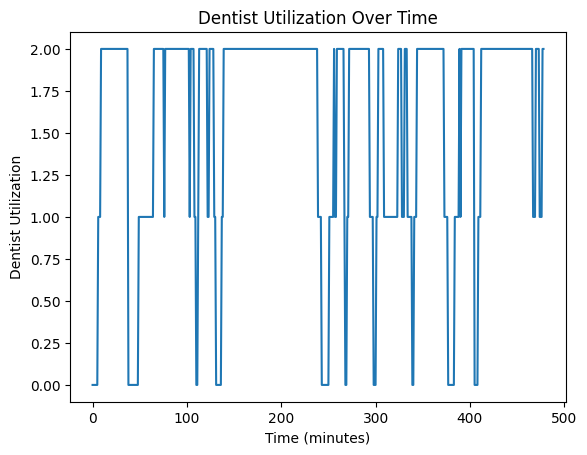

In [84]:
# line chart of dentist utilization over time
import matplotlib.pyplot as plt
plt.plot(clinic.dentist_utilization_over_time)
plt.xlabel('Time (minutes)')
plt.ylabel('Dentist Utilization')
plt.title('Dentist Utilization Over Time')
plt.show()

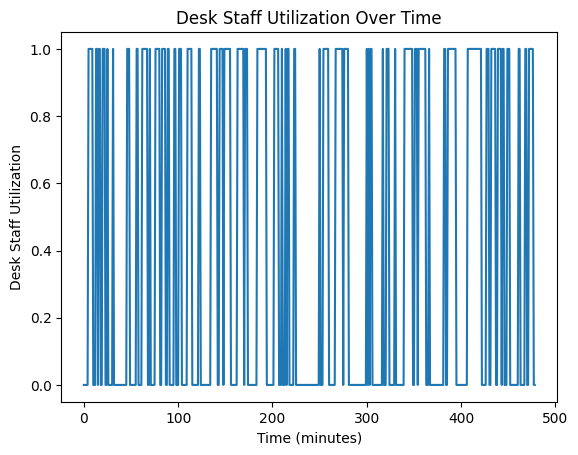

In [78]:
# line chart of dentist utilization over time
import matplotlib.pyplot as plt
plt.plot(clinic.desk_staff_utilization_over_time)
plt.xlabel('Time (minutes)')
plt.ylabel('Desk Staff Utilization')
plt.title('Desk Staff Utilization Over Time')
plt.show()

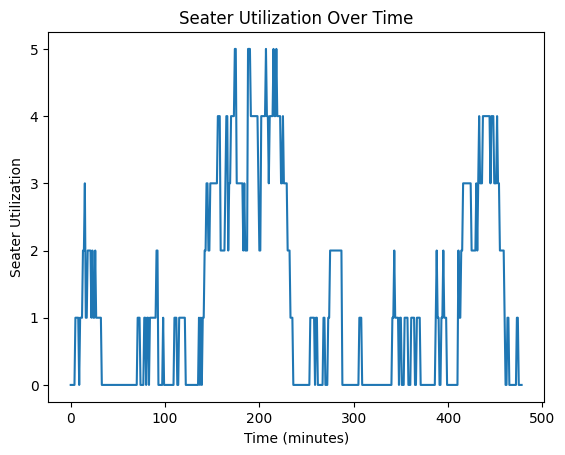

In [79]:
# line chart of dentist utilization over time
import matplotlib.pyplot as plt
plt.plot(clinic.seater_utilization_over_time)
plt.xlabel('Time (minutes)')
plt.ylabel('Seater Utilization')
plt.title('Seater Utilization Over Time')
plt.show()

In [116]:
import pandas as pd
import numpy as np

# read_csv of 'dummy_arrival.csv' with header called time 
arrival_times = pd.read_csv('dummy_arrival.csv', header=0)

# Convert the 'Arrival_Time' column to datetime
arrival_times['Arrival_Time'] = pd.to_datetime(arrival_times['Arrival_Time'], format='%H:%M')

# Define the start of working hours
start_time = pd.to_datetime('07:00', format='%H:%M')

# Calculate the inter-arrival time
arrival_times['Inter-Arrival Time'] = arrival_times['Arrival_Time'].diff().fillna(arrival_times['Arrival_Time'] - start_time)

# Convert the inter-arrival time to minutes
arrival_times['Inter-Arrival Time (Minutes)'] = arrival_times['Inter-Arrival Time'].dt.total_seconds() / 60

inter_arrival_times = arrival_times[['Inter-Arrival Time (Minutes)']]
inter_arrival_times.head()

,Inter-Arrival Time (Minutes)
0,7.0
1,1.0
2,14.0
3,8.0
4,5.0


In [117]:
inter_arrival_times.to_csv('inter_arrival_times.csv', index=False)

In [11]:
import pandas as pd
import numpy as np

inter_arrival_times = pd.read_csv('inter_arrival_times.csv')

In [12]:
import scipy.stats as stats
import numpy as np

# Extract the data as a numpy array
data = inter_arrival_times['Inter-Arrival Time (Minutes)'].values

# Fit the data to different distributions and calculate the goodness of fit
distributions = ['norm', 'expon', 'gamma', 'weibull_min']
fitting_results = []

for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(data)
    # Perform the Kolmogorov-Smirnov test
    ks_stat, ks_p_value = stats.kstest(data, dist_name, args=params)
    fitting_results.append((dist_name, params, ks_stat, ks_p_value))

# Convert the results into a DataFrame for easier interpretation
fitting_df = pd.DataFrame(fitting_results, columns=['Distribution', 'Parameters', 'KS Statistic', 'P-Value'])
fitting_df = fitting_df.sort_values(by='KS Statistic')


fitting_df


,Distribution,Parameters,KS Statistic,P-Value
2,gamma,"(2.2094314594058106, 0.22668030073619194, 5.89...",0.11650,0.536035
3,weibull_min,"(1.3503046526303777, 1.8464521845784176, 12.60...",0.12449,0.451984
0,norm,"(13.244444444444444, 9.141250961208891)",0.20163,0.044295
1,expon,"(1.0, 12.244444444444444)",0.23424,0.011792


In [13]:
import random

# Example of fitting_df for reference
# fitting_df = pd.DataFrame({
#     'Distribution': ['lognorm', 'gamma', 'norm', 'expon', 'weibull_min'],
#     'Parameters': [(0.5, 0, 1.0), (2.0, 0, 2.0), (5.0, 2.0), (1.0, 5.0), (1.5, 0, 2.0)],
#     'KS Statistic': [0.1, 0.2, 0.3, 0.4, 0.5],
#     'P-Value': [0.9, 0.8, 0.7, 0.6, 0.5]
# })

# Find the best fitting distribution based on the KS Statistic
best_fit = fitting_df.iloc[0]  # The first row after sorting by KS Statistic

# Extracting the distribution name and parameters
distribution_name = best_fit['Distribution']
params = best_fit['Parameters']

# Initialize the interarrival_distribution variable
interarrival_distribution = None

# Determine the appropriate distribution and assign to the variable
if distribution_name == 'expon':
    rate = 1.0 / params[1]  # For exponential, params[1] is the scale (mean)
    interarrival_distribution = f"random.expovariate({rate})"
elif distribution_name == 'norm':
    mean, std_dev = params
    interarrival_distribution = f"random.gauss({mean}, {std_dev})"
elif distribution_name == 'lognorm':
    sigma, loc, scale = params
    interarrival_distribution = f"random.lognormvariate({loc}, {sigma})"
elif distribution_name == 'gamma':
    shape, loc, scale = params
    interarrival_distribution = f"random.gammavariate({shape}, {scale})"
elif distribution_name == 'weibull_min':
    shape, loc, scale = params
    interarrival_distribution = f"random.weibullvariate({scale}, {shape})"
else:
    interarrival_distribution = "Unsupported distribution"

# Print the result
interarrival_distribution

'random.gammavariate(2.2094314594058106, 5.891906202792409)'

In [14]:
a = interarrival_distribution
a

'random.gammavariate(2.2094314594058106, 5.891906202792409)'

In [31]:
import random


# Using eval to assign the expression to the variable simulate
simulate = lambda: eval(a)

value = simulate()
value

16.926224215543666

In [2]:
import simpy
import random
from fitting_distribution import process_interarrival_times
import pandas as pd



In [20]:
data = pd.read_csv('optimized_schedule.csv')
data.head()

,Arrival_Time
0,8:00
1,8:30
2,8:45
3,9:05
4,9:30


In [23]:
df = process_interarrival_times(data).iloc[:,0].to_list()
df
# print all item values of df['Inter-Arrival Time (Minutes)']
for item in df:
    print(item)



60.0
30.0
15.0
20.0
25.0
15.0
15.0
15.0
25.0
25.0
25.0
15.0
15.0
15.0
15.0
15.0
15.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
